In [1]:
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
train=pd.read_csv("Digit recognizer/train.csv")
test=pd.read_csv("Digit recognizer/test.csv")

### Check Out the Data

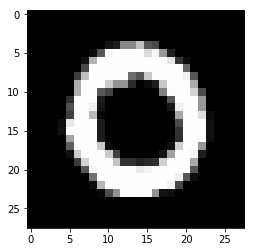

In [5]:
img = train.loc[1][1:].values.reshape((28,28))
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [7]:
train.shape

(42000, 785)

In [8]:
test.shape

(28000, 784)

In [9]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Next_batch 

Takes 100 Rows(pixel)per iteration

In [6]:
batch_num = 0
examples_num = train.shape[0]
def next_batch(batch_size):
    global batch_num
    global train

    start = batch_num
    end = batch_num + batch_size - 1

    if end > examples_num:
        train = train.sample(frac=1).reset_index(drop=True)
        batch_num = 0
        start = batch_num
        end = batch_num + batch_size - 1

    data = train.loc[start:end]
    labels = data.pop('label')
    batch_num = end + 1
    return data.values, handle_labels(labels.values)

In [7]:
def handle_labels(num_array):
    length = len(num_array)
    patten = np.zeros([length, 10])
    for i in range(length):
        patten[i][num_array[i]] = 1
    return patten

### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [8]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [9]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF:

Computes a 2-D convolution given 4-D input and filter tensors.

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape 
[filter_height, filter_width, in_channels, out_channels], this op performs the following:

1. Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
2. Extracts image patches from the input tensor to form a virtual tensor of shape [batch, out_height, out_width,
   filter_height * filter_width * in_channels].
3. For each patch, right-multiplies the filter matrix and the image patch vector

In [10]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Create a max pooling layer, again using built in TF functions:
Performs the max pooling on the input.
Args:
  value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
    type `tf.float32`.
  ksize: A list of ints that has length >= 4.  The size of the window for
    each dimension of the input tensor.
  strides: A list of ints that has length >= 4.  The stride of the sliding
    window for each dimension of the input tensor.
  padding: A string, either `'VALID'` or `'SAME'`. 

In [11]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [12]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [13]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Placeholders 

In [14]:
x = tf.placeholder(tf.float32,shape=[None,784])
y_true = tf.placeholder(tf.float32,shape=[None,10])

### Layers

In [15]:
x_image = tf.reshape(x,[-1,28,28,1])

In [16]:
# Using a 6by6 filter here, 
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of  a single image.
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [17]:
# Using a 6by6 filter here
# You can actually change the 64 output if you want, you can think of that as a representation 
#of the amount of 6by6 filters used.

convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [18]:
# Why 7 by 7 image? Because we did 2 pooling layers, so (28/2)/2 = 7
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [19]:
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [20]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [21]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer

In [22]:
train_step =  tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy)

### Saves variables

In [ ]:
saver = tf.train.Saver()

### Intialize Variables

In [ ]:
init = tf.global_variables_initializer()

### Session

In [23]:
steps = 10000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = next_batch(100)
        
        sess.run(train_step,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
           # print('step %d, training accuracy %g' % (i, sess.run(acc,feed_dict={x:batch_x,y_true:batch_y,hold_prob:1})))
            print(sess.run(acc,feed_dict={x:batch_x,y_true:batch_y,hold_prob:1}))
            print('\n')
            
    
    save_path = saver.save(sess, "model/model.ckpt")
    print("Model saved in file: %s" % save_path)

Currently on step 0
Accuracy is:
0.2


Currently on step 100
Accuracy is:
0.95


Currently on step 200
Accuracy is:
0.9


Currently on step 300
Accuracy is:
0.93


Currently on step 400
Accuracy is:
0.91


Currently on step 500
Accuracy is:
0.93


Currently on step 600
Accuracy is:
0.93


Currently on step 700
Accuracy is:
0.95


Currently on step 800
Accuracy is:
0.92


Currently on step 900
Accuracy is:
0.95


Currently on step 1000
Accuracy is:
0.95


Currently on step 1100
Accuracy is:
0.99


Currently on step 1200
Accuracy is:
0.95


Currently on step 1300
Accuracy is:
0.98


Currently on step 1400
Accuracy is:
0.99


Currently on step 1500
Accuracy is:
0.96


Currently on step 1600
Accuracy is:
0.96


Currently on step 1700
Accuracy is:
0.97


Currently on step 1800
Accuracy is:
0.98


Currently on step 1900
Accuracy is:
0.95


Currently on step 2000
Accuracy is:
0.98


Currently on step 2100
Accuracy is:
0.98


Currently on step 2200
Accuracy is:
0.98


Currently on step 2300
Ac

### Feed The Model on Test Data

In [24]:
predicted_lables = np.zeros(test.shape[0])

predict = tf.argmax(y_pred, 1)

with tf.Session() as sess:
  # Restore variables
    saver.restore(sess, "model/model.ckpt")
  # Check the values of the variables
    for i in range(0, test.shape[0]//100):
        predicted_lables[i*100 : (i+1)*100] = predict.eval(feed_dict={x: test.values[i*100 : (i+1)*100], hold_prob: 1.0})

INFO:tensorflow:Restoring parameters from model/model.ckpt


### Displays the Output

In [ ]:
plt.figure(num='astronaut',figsize=(28,28))
for i in range(0,10):  
    plt.subplot(1,10,i + 1)
    img = test.values[i].reshape((28,28))   
    plt.imshow(img, cmap=plt.get_cmap('gray'))

### Saves the File in Csv format

In [ ]:
np.savetxt('result.csv', 
           np.c_[range(1,len(test)+1), predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '',
           newline='\r\n',
           fmt='%d')